# NLP spacy + LSTM Sentiment Analysis of Amazon Product Reviews 
# Overview
This is a project of tagging "good" or "bad" Amazon product reviews (binary classification). The word embedding vectors are using state-of-the-art NLP product [spaCy](https://spacy.io/models/) and LSTM. 

What's learned?
* Using LIME to explain what consist of good or bad reviews.
* Decoding binary files directly into strings
* Parsing sentences into list of words, the "truncated" word sequence is then fed into LSTM.
* Train many-to-one Bidirectional LSTM using spaCy frozen embeddings as Embedding layers, and a TimeDistributed Dense layer.
* Small mini-batches converges faster!

# Data
The [data](https://www.kaggle.com/bittlingmayer/amazonreviews) is downloaded from Kaggle, and data cleaning and preprocessing uses the codes modified from the [kernel by Anshul Rai](https://www.kaggle.com/anshulrai/cudnnlstm-implementation-93-7-accuracy) and model training codes from [spaCy](https://spacy.io/models/). 


In [1]:
#import SentimentAnalyser # spaCy
from deep_learning_keras import SentimentAnalyser
from deep_learning_keras import get_features
#import plac # reads in command line arguments via plac.call()
#import random
#import pathlib
#import cytoolz
#import thinc.extra.datasets
#from spacy.compat import pickle
import spacy
import numpy as np 
import pandas as pd 
import bz2
import gc # garbage collector, release unused memory
import chardet
import re
import os
print(os.listdir("./input"))
from keras.models import Model, Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional, TimeDistributed, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, CuDNNLSTM
from keras.optimizers import Adam
#from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.models import load_model


Using TensorFlow backend.


['train.ft.txt.bz2.zip', 'model-5.h5', 'test.ft.txt.bz2', 'train.ft.txt.bz2']


Read in the train and test binary datasets:

In [2]:
train_file = bz2.BZ2File('./input/train.ft.txt.bz2')
test_file = bz2.BZ2File('./input/test.ft.txt.bz2')

Decoding binary files directly into a list of strings:

In [3]:
def readbinary2list(file): # 
    lines = file.readlines()
    lines = [line.decode('utf-8') for line in lines]
    labels = [0 if line.split(' ')[0] == '__label__1' else 1 for line in lines]
    sentences = [line.split(' ', 1)[1][:-1].lower() for line in lines]
    for i in range(len(sentences)):
        sentences[i] = re.sub('\d','0',sentences[i])
        if 'www.' in sentences[i] or 'http:' in sentences[i] or 'https:' in sentences[i] or '.com' in sentences[i]:
            sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", sentences[i])    
    return labels, sentences

In [4]:
train_labels,train_sentences = readbinary2list(train_file)
test_labels,test_sentences = readbinary2list(test_file)
#print(test_labels)

Checkout how the labels and product review sentences look like:

In [5]:
i=0
print('label: %s \n\nsentences: \n%s\n'%(train_labels[i],train_sentences[i]))

i=6
print('label: %s \n\nsentences: \n%s\n'%(train_labels[i],train_sentences[i]))

label: 1 

sentences: 
stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^

label: 0 

sentences: 
buyer beware: this is a self-published book, and if you want to know why--read a few paragraphs! those 0 star reviews must have been written by ms. haddon's family and friends--or perhaps, by herself! i can't imagine anyone reading the whole thing--i spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. it is most definitely bad enough to be entered into some kind of a "worst book" contest. i can't believe amazon even sells this kind of thing. maybe i can offer

In [6]:
#gc.collect() # free memory
maxlen = 100

Load spaCy word embedding vectors, and parse the strings into a list of word sequences:

In [7]:
def get_embeddings(vocab):
    return vocab.vectors.data

nlp = spacy.load('/usr/local/lib/python3.5/site-packages/spacy/data/en_core_web_lg/en_core_web_lg-2.0.0')
#nlp = spacy.load('en') # equivalent to space.load('/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/spacy/data/en')
try:
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
except:
    print('Sentencizer already loaded')
nsamp_train = 50000
nsamp_dev = round(nsamp_train/8)
embeddings = get_embeddings(nlp.vocab)


In [14]:
#print(train_labels)

[1 1 1 ... 0 1 1]


In [ ]:
print("Parsing texts...")
nsamp_dev = round(nsamp_train/8)
# create a list of words for a doc
train_docs = list(nlp.pipe(train_sentences[0:nsamp_train])) # makes a list of reviews, e.g., train_doc[0] contains the 1st review with texts separated into
train_labels = np.asarray(train_labels[0:nsamp_train], dtype='int32')

dev_docs   = list(nlp.pipe(test_sentences[0:nsamp_dev])) # makes a list of reviews, e.g., train_doc[0] contains the 1st review with texts separated into
dev_labels   = np.asarray(test_labels[0:nsamp_dev], dtype='int32')

test_docs   = list(nlp.pipe(test_sentences[nsamp_dev:2*nsamp_dev]))
test_labels   = np.asarray(test_labels[nsamp_dev:2*nsamp_dev], dtype='int32')


Map all the texts in the sentences into unique integers/features:

In [ ]:
train_X = get_features(train_docs, maxlen) 
dev_X = get_features(dev_docs, maxlen)
test_X = get_features(test_docs, maxlen)

In [ ]:
print('input dim (batch size, sequence length) = %s'%str(train_X.shape))

# Build model and run
I'm using `LSTM` here since it allows dropout regularization compared to `CuDNNLSTM` without, for this small dataset. Test `CuDNNLSTM` in the future with `Dropout` layer added before `CuDNNLSTM` with large dataset as discussed [here](https://github.com/keras-team/keras/issues/8935).

In [10]:
from keras.wrappers.scikit_learn import KerasClassifier

def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False, # don't train spaCy embedding weights
            weights=[embeddings],
            mask_zero=True
        )
    )
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False))) # linear activation defaulted
    model.add(Bidirectional(LSTM(shape['nr_hidden'], 
                                 recurrent_dropout=settings['dropout'], # drop node fraction for the recurrent state.
                                 dropout=settings['dropout']))) # drop node fraction for the inputs.
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='binary_crossentropy', metrics=['accuracy'])
    return model
nr_hidden=64
max_length=100
dropout=0.5
learn_rate=0.001
epochs=2
batch_size=16 # idk why spaCy sets mini-batch = 256 here, the paper says ideally SGD works best between 2 to 32 

shape = {'nr_hidden': nr_hidden, 'max_length': max_length, 'nr_class': 1}
settings = {'dropout': dropout, 'lr': learn_rate}
#classifier = KerasClassifier(build_fn=compile_lstm, validation_data=(dev_X, dev_labels), epochs=epochs, batch_size=batch_size, verbose=1)
classifier = KerasClassifier(build_fn=compile_lstm, epochs=epochs, batch_size=batch_size, verbose=1)
#model = compile_lstm(embeddings, shape, settings)


In [42]:
import deep_learning_keras
class Integer_list(object):
    def __init__(self, maxlen=100):
        self.maxlen=maxlen
    def fit(self, X, y=None):
#        print(X[0][0])        
        return self
    def transform(self, X, y=None):
        X = list(nlp.pipe(X))
        int_list = get_features(X, self.maxlen)
        return int_list
    
integer_list = Integer_list(maxlen)
import sklearn
from sklearn.pipeline import Pipeline

def fit(classifier, embeddings, shape, settings, integer_list, x_train, y_train): #sequencer, padder, x_train, y_train):
    pipeline = Pipeline([
#                ('sequencer', sequencer),
#                ('padder', padder),
                ('integer_list', integer_list),
                ('keras_classifier', classifier)
        ])
    pipeline.set_params(keras_classifier__embeddings=embeddings, 
                        keras_classifier__settings=settings,
                        keras_classifier__shape=shape)
    c = pipeline.fit(x_train, y_train)
    return c

c = fit(classifier, embeddings, shape, settings, integer_list, #sequencer, padder, 
        train_sentences[:nsamp_train], train_labels)


s
Epoch 1/2
50000/50000 [==============================] - 475s 9ms/step - loss: 0.3333 - acc: 0.8553
Epoch 2/2
50000/50000 [==============================] - 432s 9ms/step - loss: 0.2664 - acc: 0.8902


In [ ]:
#model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels), epochs=nb_epoch, batch_size=batch_size)

Notice training on small mini-batches (<32 samples) prevents SGD to be stuck at local minima and accelerates convergence according to the [paper](https://arxiv.org/abs/1804.07612).

In [ ]:
#model.save('model-5.h5') # no checkpoint set to save previous epochs
from joblib import dump, load
dump(c, 'model.joblib')

# Prediction
Test case of 6250 samples prediction:

In [58]:
from keras.models import load_model
#model = load_model('./input/model-5.h5')
# test_X
label_pred = c.predict_proba(test_sentences[nsamp_dev:2*nsamp_dev])


6250/6250 [==============================] - 15s 2ms/step


In [65]:
label_pred

array([0.0024448, 0.9975552], dtype=float32)

In [105]:
import tensorflow as tf
from sklearn import metrics

sess = tf.Session()
threshold = [0.5]#np.arange(0,1,0.1)
y_pred = tf.constant(np.asarray([i[1]>threshold for i in label_pred]).reshape((-1,)),dtype=tf.int64)
y_true = tf.constant(test_labels,dtype=tf.int64)
_, precision = tf.metrics.precision_at_thresholds(y_true, y_pred, threshold) # mean average precision 
_, recall = tf.metrics.recall_at_thresholds(y_true, y_pred, threshold) # mean average precision 
accuracy, update_op = tf.metrics.accuracy(y_true, y_pred)
#_, m_ap = tf.metrics.average_precision_at_k(y_true, y_pred, 10) # mean average precision for top 5 predictions, AP@k is: sum k=1:x of (precision at k * change in recall at k)
sess.run(tf.local_variables_initializer())
precision = sess.run(precision)[0]
recall = sess.run(recall)[0]
accuracy = sess.run([accuracy,update_op])[1]
#mAP = sess.run(m_ap)
F1 = 2*precision*recall/(precision+recall)
#print('mAP = %s'%mAP)
#accuracy: A Tensor representing the accuracy, the value of total divided by count.
#update_op: An operation that increments the total and count variables appropriately and whose value matches accuracy

print('accuracy  = %s'%accuracy)
print('recall    = %s'%recall)
print('precision = %s'%precision)
print('F1 score  = %s'%F1)


accuracy  = 0.90528
recall    = 0.9139475
precision = 0.89842767
F1 score  = 0.9061211435751151


For a threshold of 0.5, the scores are not bad considering training on my macbook air!

Let's look at the ROC curve and the area under ROC curve:

Area Under ROC curve = 0.9665671133764724


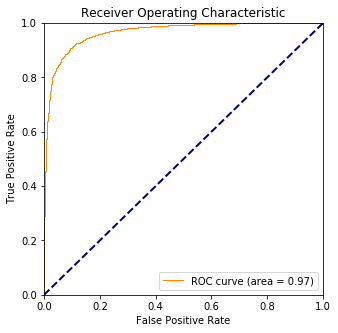

In [71]:
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib import pyplot as plt
area_under_roc = sklearn.metrics.roc_auc_score(test_labels,label_pred[:,1]) 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels,label_pred[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr) # Area Under ROC Curve
print('Area Under ROC curve = %s'%area_under_roc)

#plt.figure()
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
# ROC considers all thresholds of probabilities to plot the yellow curve
# suppose at FPR=0.1, the TPR=0.9
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

In [48]:
# create explainer object
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from lime.lime_text import LimeTextExplainer
from importlib import reload

class_names = ['bad','good']
explainer = LimeTextExplainer(class_names=class_names, split_expression=tokenize_string)

In [50]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator




idx = 85
sentence = test_sentences[idx]
print(sentence)
exp = explainer.explain_instance(sentence, c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability =', c.predict_proba([test_sentences[idx]])[0,1])
print('True class: %s' % class_names[test_labels[idx]])

ok...: this book was recommend 0 me from my neighbor. but i dont think that dis is dat gud of a book 0 recommend... i didnt like it 0 much but...
5000/5000 [==============================] - 10s 2ms/step
Document id: 85
1/1 [==============================] - 0s 20ms/step
Probability = 0.5002322
True class: bad


# Summary
The simple test of forecast shows small sample training (50,000) achieving pretty good result on a laptop using spaCy word embeddings! 

Further comparison with [TextBlob's](https://textblob.readthedocs.io/en/dev/index.html) "polarity" function might be interesting since it's build on state-of-the-art `NLTK` model.

# Reference
* [LIME explained](https://medium.com/@ageitgey/natural-language-processing-is-fun-part-3-explaining-model-predictions-486d8616813c)
* [small mini batches are good according to this paper!](https://arxiv.org/abs/1804.07612)
* [embedding layer keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
* [cuDNNLSTM keras doc](https://keras.io/layers/recurrent/)
* [cuDNNLSTM implement project](https://www.kaggle.com/anshulrai/cudnnlstm-implementation-93-7-accuracy)
* [spaCy sentiment git](https://github.com/explosion/spaCy/blob/master/examples/deep_learning_keras.py)
* [spaCy](https://spacy.io/models/)
* [Python kaggle docker](https://github.com/Kaggle/docker-python/blob/master/Dockerfile)
* [TextBlob](https://textblob.readthedocs.io/en/dev/index.html)
* [Dropout applied before CuDNNLSTM](https://github.com/keras-team/keras/issues/8935)
* [Visualize word embedding with PCA projection](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)
* [DictVetorizer turns text to list of words](https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html#sphx-glr-auto-examples-text-plot-hashing-vs-dict-vectorizer-py)

In [ ]:
# This code from https://data4thought.com/deep-lime.html can directly 
# turn sentences into a list of words
class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        

class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X



#vocab_size = 684800
#sequencer = TextsToSequences(num_words=vocab_size)
#padder = Padder(maxlen)
def tokenize_string(string):
    return string.split()

def strip_formatting(string):
    string = string.lower()
    string = re.sub(r"([.!?,'/()])", r" \1 ", string)
    return string